In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import string

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
import re
from collections import Counter

In [2]:
df = pd.read_json('../data/lyrics_cleaned.json')

In [3]:
df.head()

,artist,title,lyrics,character_count,word_count
0,Drake,Toosie Slide,"Black leather gloves, no sequins (Yeah, yeah, ...",2371,447
1,Roddy Ricch,The Box,Pullin' out the coupe at the lot Told 'em fuc...,2689,551
2,Dua Lipa,Don't Start Now,"If you don't wanna see me Did a full 180, cra...",1576,304
3,Doja Cat,Say So,"Day and night til morning, keeping me in the m...",2203,446
4,Post Malone,Circles,"Hey, hey, hey, hey Oh, oh, oh-oh Oh, oh, oh-...",1570,318


In [4]:
df.reset_index(drop=True,inplace=True)

In [5]:
df.iloc[6247,:]['lyrics']

">Freaky Tahverses Mr. CheeksIntro:[Freaky Tah]Everybody's buckin, don't give it a damneverbody...everbody(echo)Verse 1[Mr.Cheeks]Straight from cop killer Queensa juvenile named Jack >Jackat the age of 17 >uh huhyo this kid Jack started slingin crack >started slingin crackhe's on the road to riches >richesbaggin bitches >bitcheshe's in clubs takin pitchersdrink your finger always into sesshis lifestyles buckwild honey child >yeahgot a shorty named Val >Valshe stays on the Isle >ahhhhe started slingin at the age of 17 >uhh huhhis hearts made of steel >eh yokid his minds full of green >full of greenhe got his first ouncemade a grand 400 >hundred3 bills to get freshhe other bills to get blunted >to be bluntedand wit the letter G >Ghe bought the letter O >Onext thing you know manhe's rakin in the dough >rakin in the doughhe put his people downcuz say thats only right >aightfor dem to get keysdem and dem is mad tight >is mad tightset-up organation organize on the block>organize...blocknobod

In [6]:
df = df.drop(['character_count', 'word_count'], axis=1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6252 entries, 0 to 6251
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  6252 non-null   object
 1   title   6252 non-null   object
 2   lyrics  6252 non-null   object
dtypes: object(3)
memory usage: 146.7+ KB


In [8]:
df.head()

,artist,title,lyrics
0,Drake,Toosie Slide,"Black leather gloves, no sequins (Yeah, yeah, ..."
1,Roddy Ricch,The Box,Pullin' out the coupe at the lot Told 'em fuc...
2,Dua Lipa,Don't Start Now,"If you don't wanna see me Did a full 180, cra..."
3,Doja Cat,Say So,"Day and night til morning, keeping me in the m..."
4,Post Malone,Circles,"Hey, hey, hey, hey Oh, oh, oh-oh Oh, oh, oh-..."


In [9]:
df.tail()

,artist,title,lyrics
6247,Lost Boyz,Lifestyles Of The Rich And Shameless,>Freaky Tahverses Mr. CheeksIntro:[Freaky Tah]...
6248,DJ Quik,Safe + Sound,"~Static~ ""Quik you're not a gangster we're not..."
6249,Ty Herndon,What Mattered Most,I thought I knew the girl so well If she was ...
6250,Madonna,Bedtime Story,Today Is the last day That I'm using words ...
6251,Livin' Joy,Dreamer,"Love, life and laughter Is all I beleive. My..."


In [10]:
# class predictors(TransformerMixin):
#     def transform(self, X, **transform_params):
#         return [clean_text(text) for text in X]

#     def fit(self, X, y=None, **fit_params):
#         return self

#     def get_params(self, deep=True):
#         return {}

# def clean_text(text):
#     return text.strip().lower()

In [11]:
# idx = np.random.randint(0, 6252)
# text = df.iloc[idx, 1]
# text

In [12]:
punctuations = string.punctuation
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
parser = English()


def remove_bracketed(song):
    text = re.sub("\[.*?\]", '', song)
    text = re.sub("\(.*?\)", '', text)
    text = re.sub("\{.*?\}", '', text)
    
    return text


def spacy_tokenizer(text, use_stopwords=True, custom_stopwords=set()):
    text = remove_bracketed(text)
    mytokens = parser(text)
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    if use_stopwords:
        mytokens = [word for word in mytokens if word not in (stop_words | custom_stopwords) and word not in punctuations ]
    else:
        mytokens = [word for word in mytokens if word not in punctuations ]

    
    return mytokens


def tokenize_column(dataframe, column_name, use_stopwords=True, custom_stopwords=set()):
    df_ = dataframe.reset_index(drop=True)
    token_list = []
    for song in df_[column_name]:
        token_list.append(spacy_tokenizer(song, use_stopwords, custom_stopwords))
    
    return token_list



In [13]:
lyric_stopwords = set(['hey', 'baby', 'woo', 'ha', 'like', 'oh', 'ooh', 'woah'])
df['lyrics_tokens'] = tokenize_column(df, 'lyrics', use_stopwords=True, custom_stopwords=lyric_stopwords)

In [14]:
df.head(10)

,artist,title,lyrics,lyrics_tokens
0,Drake,Toosie Slide,"Black leather gloves, no sequins (Yeah, yeah, ...","[black, leather, glove, sequin, buckles, jacke..."
1,Roddy Ricch,The Box,Pullin' out the coupe at the lot Told 'em fuc...,"[pullin, coupe, lot, told, 'em, fuck, 12, fuck..."
2,Dua Lipa,Don't Start Now,"If you don't wanna see me Did a full 180, cra...","[wanna, 180, crazy, thinking, way, heartbreak,..."
3,Doja Cat,Say So,"Day and night til morning, keeping me in the m...","[day, night, til, morning, moment, let, know, ..."
4,Post Malone,Circles,"Hey, hey, hey, hey Oh, oh, oh-oh Oh, oh, oh-...","[turn, til, upside, bad, guy, proud, try, beli..."
5,Justin Bieber Featuring Quavo,Intentions,"Picture perfect, you don't need no filter Gor...","[picture, perfect, need, filter, gorgeous, 'em..."
6,DaBaby Featuring Roddy Ricch,ROCKSTAR,"Woo, woo I pull up like How you pull up, Bab...","[pull, pull, pull, pull, pull, let, brand, new..."
7,Future Featuring Drake,Life Is Good,Workin' on the weekend like usual Way off in ...,"[workin, weekend, usual, way, deep, end, usual..."
8,Billie Eilish,everything i wanted,I had a dream I got everything I wanted Not ...,"[dream, want, think, bein, honest, nightmare, ..."
9,Camila Cabello Featuring DaBaby,My Oh My,"Ha, ha, ha, ha They say he likes a good time ...","[good, time, come, alive, midnight, mama, trus..."


In [15]:
idx = np.random.randint(0, 6252)

In [16]:
print(df.iloc[idx, 0], ' - ', df.iloc[idx, 1],'\n\n-----\n\n', df.iloc[idx, 2], '\n\n-----\n\n', df.iloc[idx, 3])

Of Monsters And Men  -  Little Talks 

-----

 Hey! Hey! Hey!  I don't like walking around this old and empty house  So hold my hand, I'll walk with you my dear   The stairs creak as I sleep, it's keeping me awake  It's the house telling you to close your eyes  Some days I can't even trust myself  It's killing me to see you this way    'Cause though the truth may vary  This ship will carry  Our bodies safe to shore    Hey! Hey! Hey!  There's an old voice in my head that's holding me back  Well tell her that I miss our little talks  Soon it will all be over and buried with our past  We used to play outside when we were young,  And full of life and full of love    Some days I don't know if I am wrong or right  Your mind is playing tricks on you, my dear    'Cause though the truth may vary  This ship will carry  Our bodies safe to shore    Hey!  Don't listen to a word I say  Hey!  The screams all sound the same  Hey!    Though the truth may vary  This ship will carry  Our bodies safe to s

In [17]:
barbra = df[df['artist'] == 'Duck Sauce']['lyrics'][2191]

In [18]:
barbra

'Barbra Streisand  Woowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoow  Oowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowo   Owoowoowoowoowoo  Barbra Streisand    Woowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoow  Oowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowo  Owoowoowoowoowoo    Barbra Streisand    Woowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoow  Oowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowo  Owoowoowoowoowoo    Barbra Streisand    Woowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoow  Oowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowo  Owoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoo  Woowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoow  Oowoowoowoowoowoowoowoowoowoowoowoowoo    Barbra Streisand    Woowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoow  Oowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowo  Owoowoowoowoowoo    Barbra Streisand    Wowowo wowowo wowowowoowoo  Woowoowoowoowoowoowoowoowoowoowoo wowowo wowowo 

In [19]:
set((re.sub("woo*", '', barbra.lower())).split())

{'(merci',
 'barbra',
 'cettes',
 'hugo',
 'o',
 'oo',
 'paroles)',
 'pour',
 'streisand',
 'w',
 'à'}

In [20]:
df.head()

,artist,title,lyrics,lyrics_tokens
0,Drake,Toosie Slide,"Black leather gloves, no sequins (Yeah, yeah, ...","[black, leather, glove, sequin, buckles, jacke..."
1,Roddy Ricch,The Box,Pullin' out the coupe at the lot Told 'em fuc...,"[pullin, coupe, lot, told, 'em, fuck, 12, fuck..."
2,Dua Lipa,Don't Start Now,"If you don't wanna see me Did a full 180, cra...","[wanna, 180, crazy, thinking, way, heartbreak,..."
3,Doja Cat,Say So,"Day and night til morning, keeping me in the m...","[day, night, til, morning, moment, let, know, ..."
4,Post Malone,Circles,"Hey, hey, hey, hey Oh, oh, oh-oh Oh, oh, oh-...","[turn, til, upside, bad, guy, proud, try, beli..."


In [21]:
len(df.columns)

4

In [22]:
df['word_count'] = 0
df['unique_word_count'] = 0
for idx, row in enumerate(df['lyrics']):
    df.iloc[idx, len(df.columns)-2] = len(row.split())
    df.iloc[idx, len(df.columns)-1] = len(set(row.split()))

    
df['token_count'] = 0
df['unique_token_count'] = 0
for idx, row in enumerate(df['lyrics_tokens']):
    df.iloc[idx, len(df.columns)-2] = len(row)
    df.iloc[idx, len(df.columns)-1] = len(set(row))

In [23]:
df.head()

,artist,title,lyrics,lyrics_tokens,word_count,unique_word_count,token_count,unique_token_count
0,Drake,Toosie Slide,"Black leather gloves, no sequins (Yeah, yeah, ...","[black, leather, glove, sequin, buckles, jacke...",447,166,192,71
1,Roddy Ricch,The Box,Pullin' out the coupe at the lot Told 'em fuc...,"[pullin, coupe, lot, told, 'em, fuck, 12, fuck...",551,209,240,124
2,Dua Lipa,Don't Start Now,"If you don't wanna see me Did a full 180, cra...","[wanna, 180, crazy, thinking, way, heartbreak,...",304,100,79,30
3,Doja Cat,Say So,"Day and night til morning, keeping me in the m...","[day, night, til, morning, moment, let, know, ...",446,164,130,74
4,Post Malone,Circles,"Hey, hey, hey, hey Oh, oh, oh-oh Oh, oh, oh-...","[turn, til, upside, bad, guy, proud, try, beli...",318,118,119,37


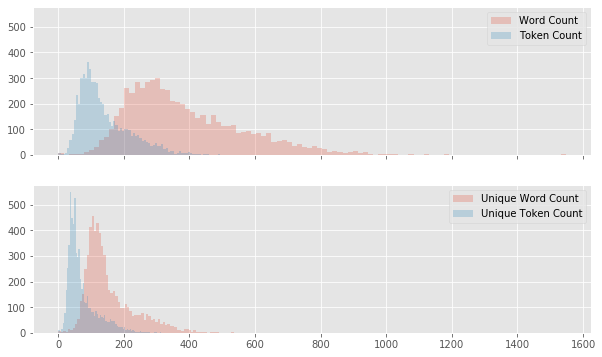

In [70]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)
ax[0].hist(df['word_count'], bins=100, label='Word Count', alpha=.25)
ax[0].hist(df['token_count'], bins=100, label='Token Count', alpha=.25)
ax[1].hist(df['unique_word_count'], bins=100, label='Unique Word Count', alpha=.25)
ax[1].hist(df['unique_token_count'], bins=100, label='Unique Token Count', alpha=.25)
ax[0].legend(loc='best')
ax[1].legend(loc='best');

''

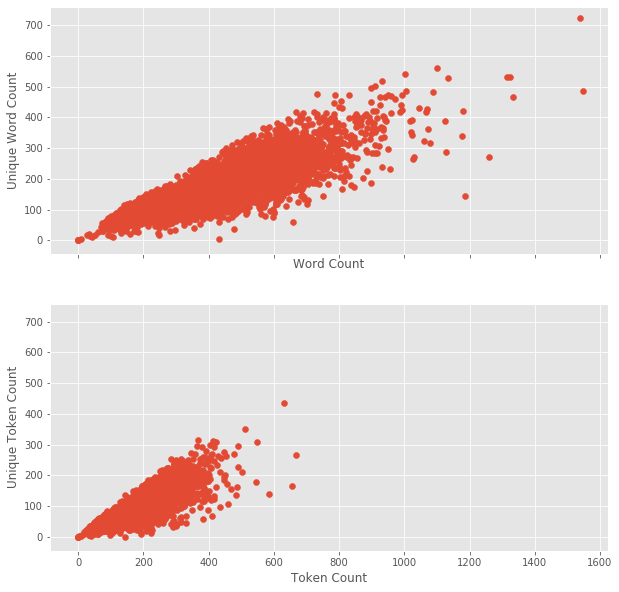

In [57]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True, sharey=True)
ax[0].scatter(df['word_count'], df['unique_word_count'])
ax[1].scatter(df['token_count'], df['unique_token_count'])
ax[0].set_xlabel('Word Count')
ax[1].set_xlabel('Token Count')
ax[0].set_ylabel('Unique Word Count')
ax[1].set_ylabel('Unique Token Count')
;

In [55]:
df[(df['word_count'] > 1100) & (df['unique_word_count'] < 200)]

,artist,title,lyrics,lyrics_tokens,word_count,unique_word_count,token_count,unique_token_count
6147,Nicki French,Total Eclipse Of The Heart,"Turnaround, Every now and then I get a little ...","[turnaround, little, bite, lonely, come, round...",1186,143,384,59


In [83]:
idx = df[(df['word_count'] > 1100) & (df['unique_word_count'] < 200)].index[0]
wc = df.iloc[idx,:]['word_count']
unique = df.iloc[idx,:]['unique_word_count']
print(unique / wc)

0.1205733558178752


In [85]:
df.iloc[idx,:]['lyrics']

"Turnaround, Every now and then I get a little bit lonely and you're never coming round  Turnaround, Every now and then I get a little bit tired of listening to the sound of my tears  Turnaround, Every now and then I get a little bit nervous that the best of all the years have gone by   Turnaround, Every now and then I get a little bit terrified and then I see the look in your eyes  Turnaround bright eyes, Every now and then I fall apart  Turnaround bright eyes, Every now and then I fall apart    Turnaround, Every now and then I get a little bit restless and I dream of something wild  Turnaround, Every now and then I get a little bit helpless and I'm lying like a child in your arms  Turnaround, Every now and then I get a little bit angry and I know I've got to get out and cry  Turnaround, Every now and then I get a little bit terrified but then I see the look in your eyes  Turnaround bright eyes, Every now and then I fall apart  Turnaround bright eyes, Every now and then I fall apart  

In [58]:
df[(df['word_count'] < 750) & (df['unique_word_count'] > 450)]

,artist,title,lyrics,lyrics_tokens,word_count,unique_word_count,token_count,unique_token_count
6127,Kool G Rap,Fast Life,"(feat. Nas) The time has come, we gotta expan...","[time, come, expand, operation, distribution, ...",732,477,369,316


In [81]:
idx = df[(df['word_count'] < 750) & (df['unique_word_count'] > 450)].index[0]
wc = df.iloc[idx,:]['word_count']
unique = df.iloc[idx,:]['unique_word_count']
print(unique / wc)

0.6516393442622951


In [82]:
df.iloc[idx,:]['lyrics']

'(feat. Nas)  The time has come, we gotta expand, the whole operation   Distribution, New York, to Chicago, L.A.  We gotta set our own market, and enforce it  [Verse One: Kool G Rap]    Champagne wishes of caviar dreams ?a penis didn\'t cream?  With sales of fish scales from triple beams I gleam  Livin the live of rowdy packin fifty cali\'s  Rockin lizard Bally\'s while we do our drug deal in a dark alley  Up in casinos just me and my dino primo  Pushin beam-o\'s then parlay in Reno with two fly latinos  Nas, he runs the whole staff, we count mad for seen bad  We\'ve seen a half a milli dashin out there on the Queens half  Three major players gettin papers by the layers  And those that portray us on the block get rocked like Domateus  Fakers get used to shootin targets, soon as the dark hits  Front on the drug market, bodies get rolled up in a carpet  Those that cheat us try to beat us we got hookers with heaters  that\'ll stray pop and put more shells in your top than Adidas  Da leade

In [67]:
df[df['title'] == 'Rap God']

,artist,title,lyrics,lyrics_tokens,word_count,unique_word_count,token_count,unique_token_count
1520,Eminem,Rap God,"Look, I was gonna go easy on you not to hurt y...","[look, easy, hurt, feeling, chance, wrong, fee...",1539,722,630,435


In [69]:
wc = df[df['title'] == 'Rap God']['word_count'][1520]
unique = df[df['title'] == 'Rap God']['unique_word_count'][1520]
print(unique / wc)

0.4691358024691358


In [71]:
df[(df['token_count'] > 600) & (df['unique_token_count'] >400)]

,artist,title,lyrics,lyrics_tokens,word_count,unique_word_count,token_count,unique_token_count
1520,Eminem,Rap God,"Look, I was gonna go easy on you not to hurt y...","[look, easy, hurt, feeling, chance, wrong, fee...",1539,722,630,435


In [98]:
top_artist = df.groupby(by='artist').count().sort_values(by='title',ascending=False).loc[:,'title']
top_artist[:50]

artist
Taylor Swift           58
Kenny Chesney          42
Tim McGraw             39
Keith Urban            37
Drake                  33
Rascal Flatts          32
Brad Paisley           32
George Strait          30
Toby Keith             30
Jason Aldean           29
Carrie Underwood       28
Blake Shelton          27
Eminem                 26
Rihanna                25
Luke Bryan             25
Kelly Clarkson         23
P!nk                   23
Dierks Bentley         23
Beyonce                23
Britney Spears         22
Alan Jackson           21
Usher                  20
Madonna                20
Maroon 5               19
Chris Brown            19
Brooks & Dunn          18
R. Kelly               18
Katy Perry             18
J. Cole                17
Nickelback             17
Montgomery Gentry      17
Eric Church            17
Miranda Lambert        17
Justin Timberlake      17
Kendrick Lamar         16
Billy Currington       16
Dixie Chicks           16
Lady Antebellum        16
Jake 

In [154]:
artist_list = ['Eminem', 'Britney Spears']
working_df = df[df['artist'].isin(artist_list)]

In [155]:
working_df

,artist,title,lyrics,lyrics_tokens,word_count,unique_word_count,token_count,unique_token_count
84,Eminem,Darkness,"I don't wanna be alone, I don't wanna be I do...","[wanna, wanna, wanna, darkness, wanna, darknes...",896,390,295,215
114,Eminem,Premonition (Intro),"Yeah So I guess this is what it is, huh? Thi...","[yeah, guess, huh, think, obvious, eye, eye, f...",576,317,214,172
117,Eminem,In Too Deep,"""This could never work,"" is what we said at fi...","[work, ﻿1, work, different, world, husband, gi...",568,270,140,109
124,Eminem,Marsh,"My name is Marsh and this world, I'm out of it...","[marsh, world, b, c, shit, startin, sound, alp...",775,397,298,221
131,Eminem,Stepdad,"Hey, yo (This song's about) My, my stepdad ...","[yo, stepdad, hate, stepdad, thing, stick, cra...",636,320,250,186
384,Eminem,Venom,I got a song filled with shit for the strong w...,"[song, fill, shit, strong, world, raw, deal, s...",867,391,378,241
388,Eminem,Killshot,"You sound like a bitch, bitch Shut the fuck u...","[sound, bitch, bitch, shut, fuck, fan, haters,...",1002,540,414,311
1520,Eminem,Rap God,"Look, I was gonna go easy on you not to hurt y...","[look, easy, hurt, feeling, chance, wrong, fee...",1539,722,630,435
1557,Eminem,Berzerk,"Now this sht's about to kick off, this party ...","[sht, kick, party, look, wack, let, straight, ...",679,325,320,199
1585,Eminem,Survival,[Hook: Liz Rodrigues] This is survival of the...,"[survival, fit, die, winner, ready, millionair...",781,356,265,197


In [122]:
song_is_artist = pd.get_dummies(working_df['artist'], prefix='is')

In [150]:
def tf(term, document_tokens):
    term_occ = document_tokens.count(term)
    total_tokens = len(document_tokens)

    return term_occ / total_tokens



In [ ]:
def get_tf(document_tokens):
    term_freqs = {}
    for token in document_tokens:
        if token not in term_freqs:
            term_freqs[token] = tf(token, document_tokens)
    
    return term_freqs
    

In [139]:
def get_idf_dict(corpus):
    occ_dict = {}
    for doc in corpus:
        for token in doc:
            if token not in occ_dict:
                occ_dict[token] = 1
            else:
                occ_dict[token] += 1
    return occ_dict

In [186]:
def get_doc_freq_dict(corpus):
    doc_occs = Counter([word for row in corpus for word in set(row)])
    doc_freq = {k: (v / float(len(docs))) for k, v in doc_occs.items()}
    return doc_freq

In [ ]:
# def get_tfidf(corpus):
#     idfs = get_doc_freq_dict(corpus)
#     for row in corpus:
        

In [200]:
docs = working_df['lyrics_tokens'].to_numpy()
vectors = np.zeros((len(docs),len(vocabulary)))
doc_freq = get_doc_freq_dict(working_df['lyrics_tokens'])
vocabulary = [k for k,v in doc_freq.items()]

for i in range(len(docs)):
    for j in range(len(vocabulary)):
        term     = vocabulary[j]
        term_tf  = tf(term, docs[i])   # 0.0 if term not found in doc
        term_idf = np.log(1 + (1 / doc_freq[term])) # smooth formula
        vectors[i,j] = term_tf * term_idf

In [202]:
vectors.shape

(48, 2826)